In [1]:
import os
import json
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn import metrics
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

# saving models
from sklearn.externals import joblib

# incase we want to try some cleaning steps to see if it improves the model
import Clean_Function_Helpers as cfh
# Functions to fit, cross validate and test all models
import Modeling_Helpers as mh

/Users/rick.shapiro/anaconda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
if not os.path.isdir('saved_models/'):
    os.mkdir('saved_models')
if not os.path.isdir('saved_models/regular/'):
    os.mkdir('saved_models/regular/')
if not os.path.isdir('saved_models/undersampled/'):
    os.mkdir('saved_models/undersampled/')
if not os.path.isdir('saved_models/oversampled/'):
    os.mkdir('saved_models/oversampled/')

In [3]:
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (9,6)
sns.set_style('darkgrid')

SEED = 1111

In [4]:
def save_best_models(results, suffix):
    
    # Save The Best Ones
    best_lr = [{'f1':0}]
    best_rf = [{'f1':0}]
    best_et = [{'f1':0}]
    best_knn = [{'f1': 0 }]

    for label, (mod,x,y,stats) in results.items():
        if 'LogisticRegression' in label:
            if stats['f1'] > best_lr[-1]['f1']:
                best_lr = (label,stats)
        if 'RandomForest' in label:
            if stats['f1'] > best_rf[-1]['f1']:
                best_rf = (label,stats)
        if 'ExtraTrees' in label:
            if stats['f1'] > best_et[-1]['f1']:
                best_et = (label,stats)
        if 'Neighbors' in label:
            if stats['f1'] > best_knn[-1]['f1']:
                best_knn = (label,stats)

    with open(f'best_models_{suffix}', 'w') as f:
        f.writelines([l+'\n' for (l,s) in [best_lr, best_rf, best_et, best_knn]])
        
    # Save Results
    for (label, stats) in [best_lr, best_rf, best_et, best_knn]:
        joblib.dump(results[label][0], f'saved_models/{suffix}/{label}.joblib')
        with open(f'saved_models/{suffix}/{label}_Stats.json', 'w') as f:
            json.dump(stats, f)

## Overview

Taking two different approaches. 

    1. Try to model the difference between real and fraudulent charges.
        - Classifiers like Logistic Regression, Tree Ensembles etc
        - Sampling approaches over vs undersampling
    2. Try to identify core boundary of real charges and identify anything outside this boundary as fraudulent.
        - Covariance estimates, Local Outlier Factor, Clustering, One Class SVM, Hierarchical Clustering, 
        Model-based bayesian clustering.
        
This notebook focuses on the first approach: using classification algorithms to predict fraudulent charges.

### Read Data

In [5]:
original = pd.read_csv('creditcard.csv')
outlier_ftrs = pd.read_csv('Outlier_Ftrs.csv')


df=pd.concat([original,outlier_ftrs],axis=1)
df.shape

(284807, 37)

### Classifiers

Here we cross-validate a few classifiers on the raw data via the following steps:

    1. Take a small sample of the data set for training. This both reduces training time and gives us a large test set for validation. Make sure the Class proportions are the same in the sample as the test dataset.
        * Note that the training set has only about 100 fraudulent cases in it.
    2. Fit a classifier using Cross-validated grid search on the training set.
    3. Use the final estimator to make predictions on the test set and calculate precision and recall.

In [6]:
# We will test different transforms of the data

sub_cols = df.columns.drop(['Time', 'Class'])

scaled_df = cfh.scale_data(df, MinMaxScaler(), sub_cols)
deskewed = cfh.deskew_df(scaled_df, topn=10)


In [72]:
# Parameters for grid search
class_weights = [{0:p, 1:1-p} for p in [0.1, 0.25, 0.5, 0.75, 0.9]]
lr_params = {
    'penalty': ['l1', 'l2'], 
    'C': [0.01, 0.1, 0.5, 1, 10],
    'class_weight': class_weights
}

tree_params = {
    'n_estimators': [10, 50,100, 150, 250],
    'max_depth': [3,5,10,15,25],
    'criterion': ['gini', 'entropy'],
    'class_weight': class_weights
}


knn_params = {
    'n_neighbors': [1,3,5,10,15,25],
    'weights': ['uniform', 'distance']
}

In [8]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V27,V28,Amount,Class,robust_mahalanobis_dists,lof,iso_forest,ocsvm,km_labels,gmm_labels
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.133558,-0.021053,149.62,0,797.247862,-1.018992,0,0,89,4
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.008983,0.014724,2.69,0,9.840797,-1.109327,0,0,9,10
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,-0.055353,-0.059752,378.66,0,327.155932,-1.027865,0,0,73,6
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.062723,0.061458,123.50,0,43.149182,-1.048658,0,0,91,6
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.219422,0.215153,69.99,0,13765.631355,-1.021926,0,0,52,4


EVALUATING: Regular -- LogisticRegression

Train Distribution of Target Class
0    56859
1      102
Name: Class, dtype: int64

Best Params: {'C': 0.1, 'class_weight': {0: 0.25, 1: 0.75}, 'penalty': 'l1'}
Best Score: 0.8016679208108741
F1: 0.8161073825503355
Recall: 0.7794871794871795
Precision: 0.856338028169014
Threshold: 0.32

EVALUATING: Regular -- RandomForestClassifier

Train Distribution of Target Class
0    56859
1      102
Name: Class, dtype: int64

Best Params: {'class_weight': {0: 0.25, 1: 0.75}, 'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 250}
Best Score: 0.8346122124738994
F1: 0.8189189189189189
Recall: 0.7769230769230769
Precision: 0.8657142857142858
Threshold: 0.38

EVALUATING: Regular -- ExtraTreesClassifier

Train Distribution of Target Class
0    56859
1      102
Name: Class, dtype: int64

Best Params: {'class_weight': {0: 0.1, 1: 0.9}, 'criterion': 'entropy', 'max_depth': 15, 'n_estimators': 250}
Best Score: 0.8341165171574613
F1: 0.8394062078272606
Recall

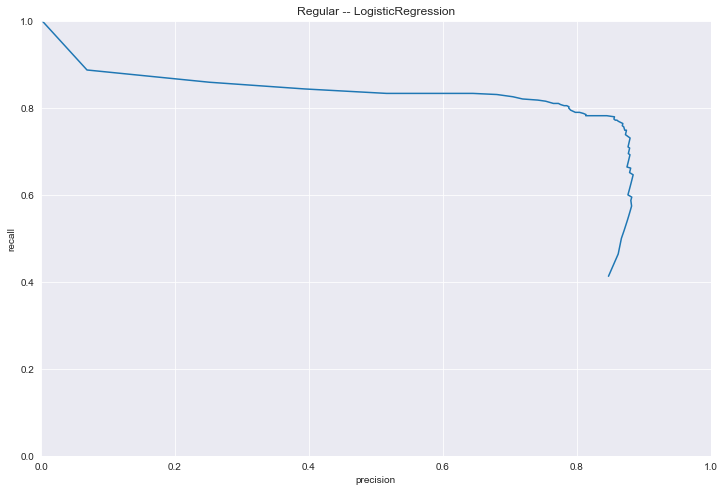

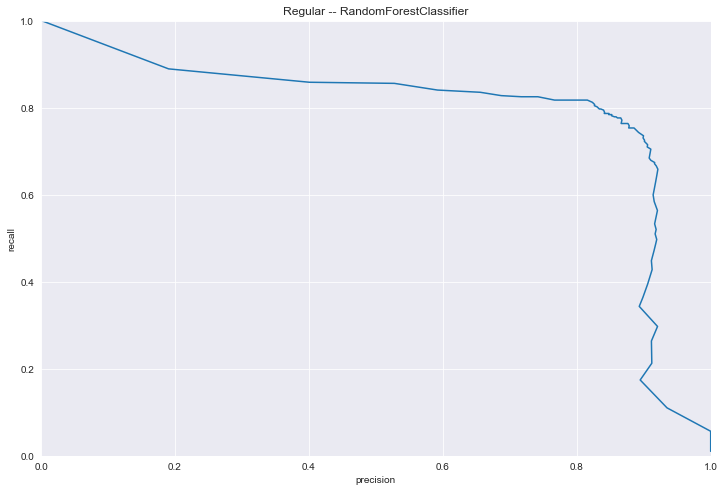

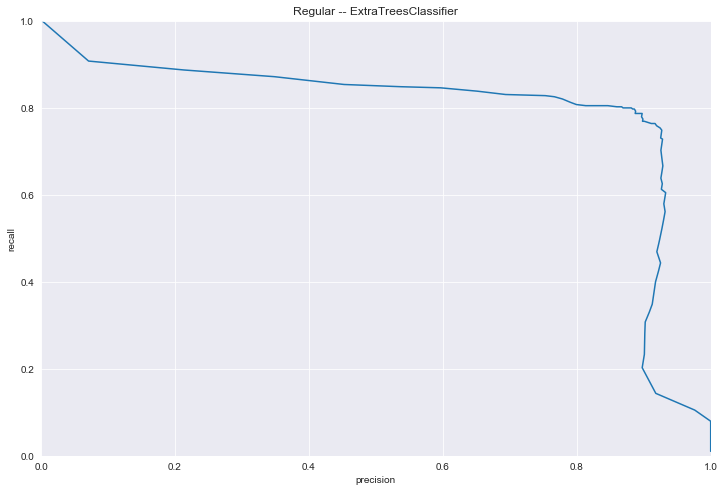

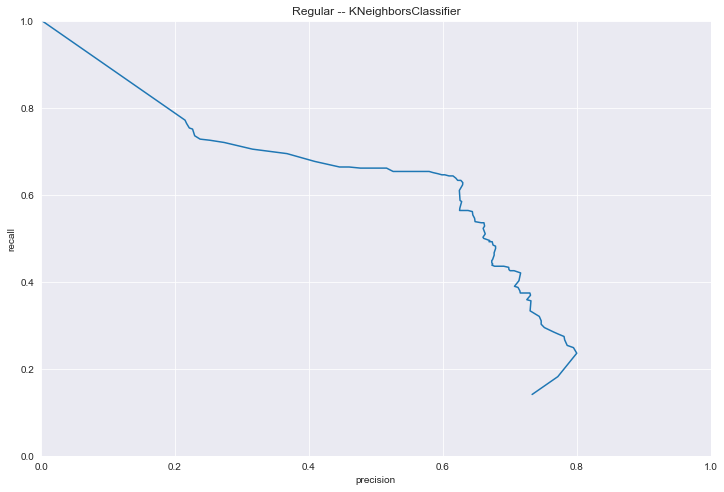

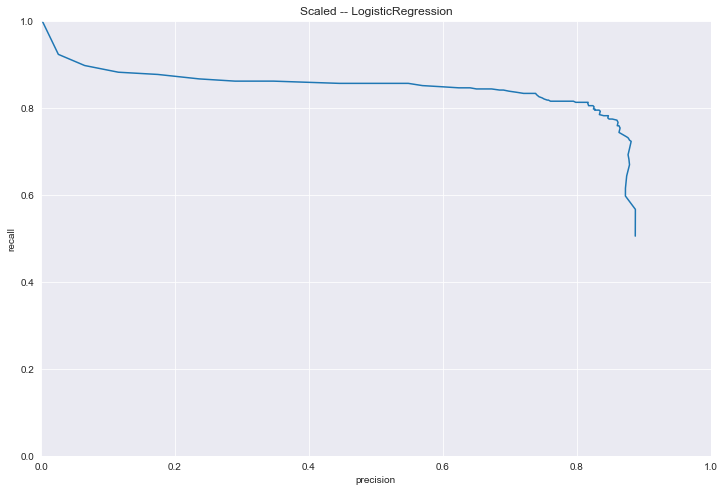

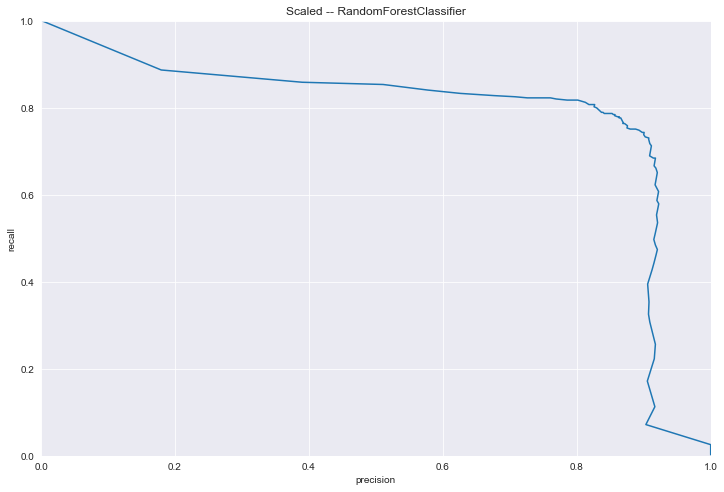

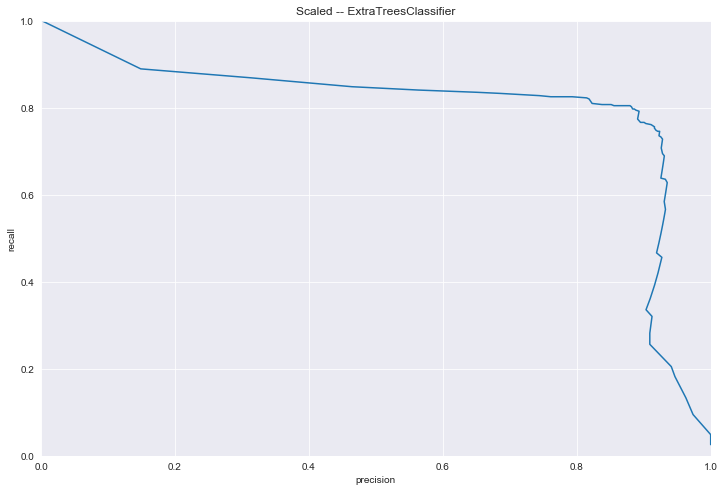

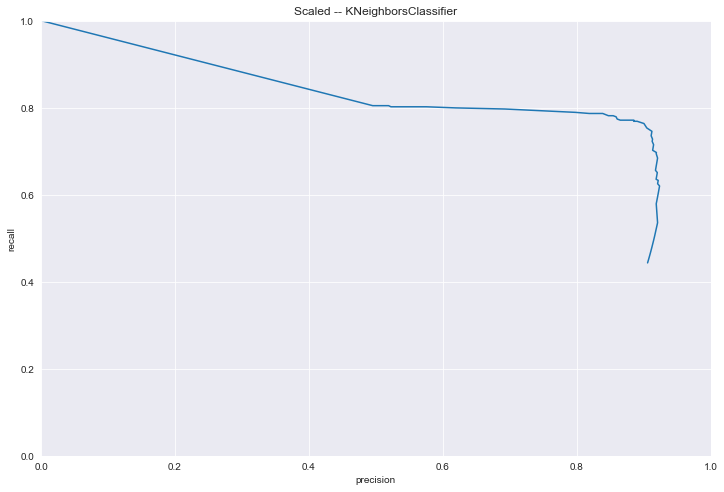

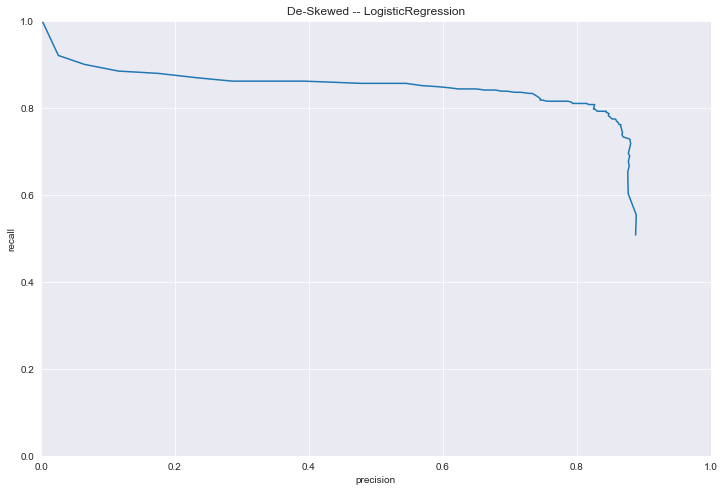

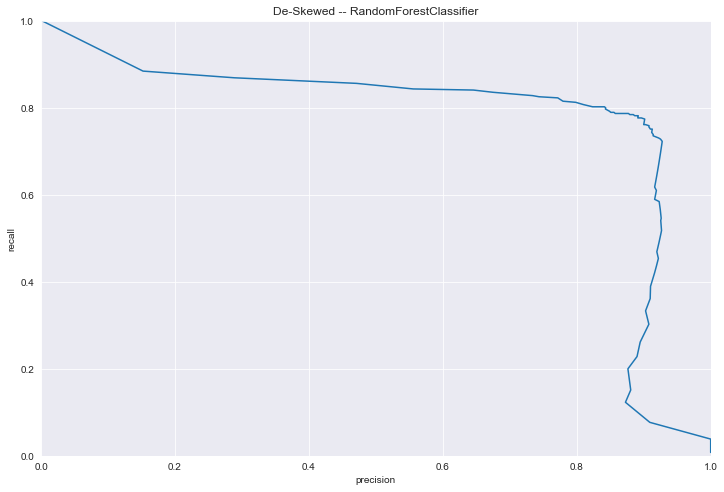

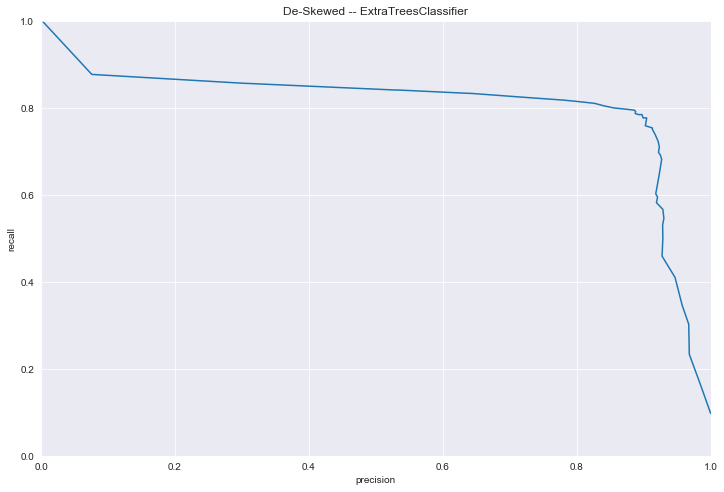

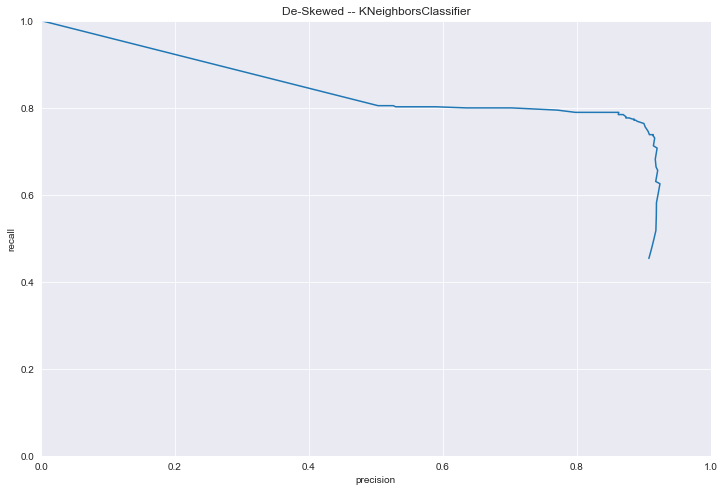

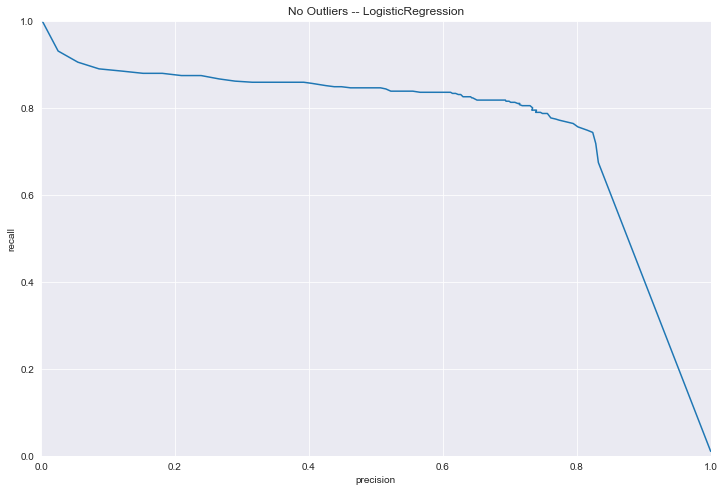

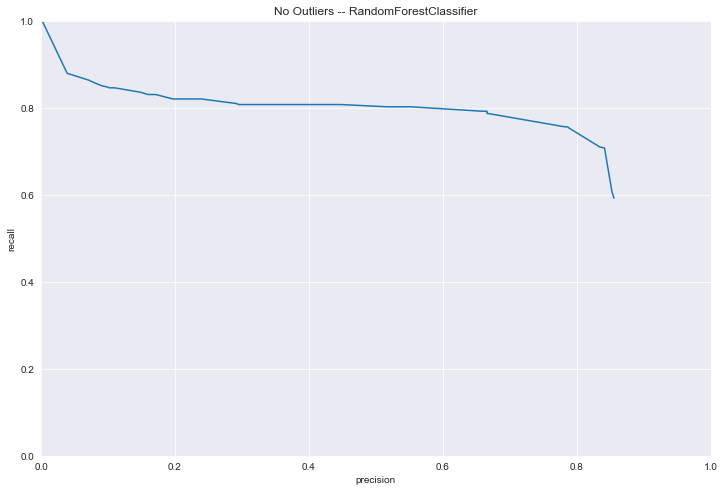

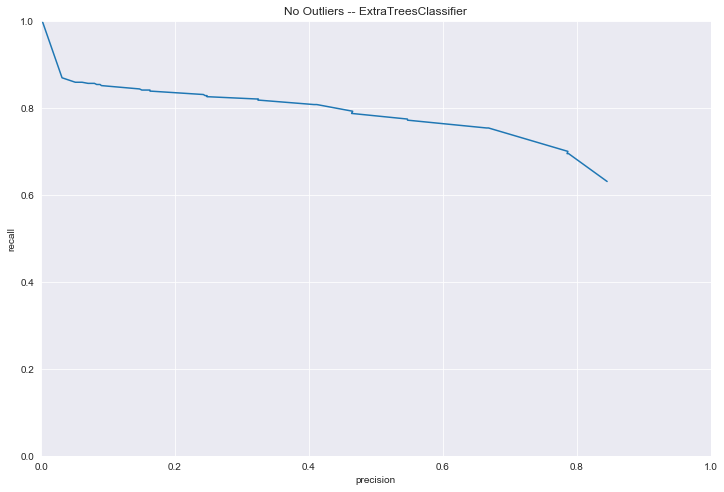

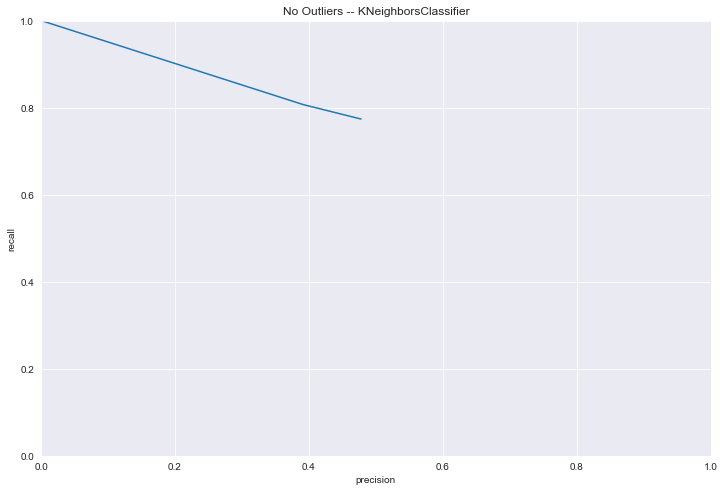

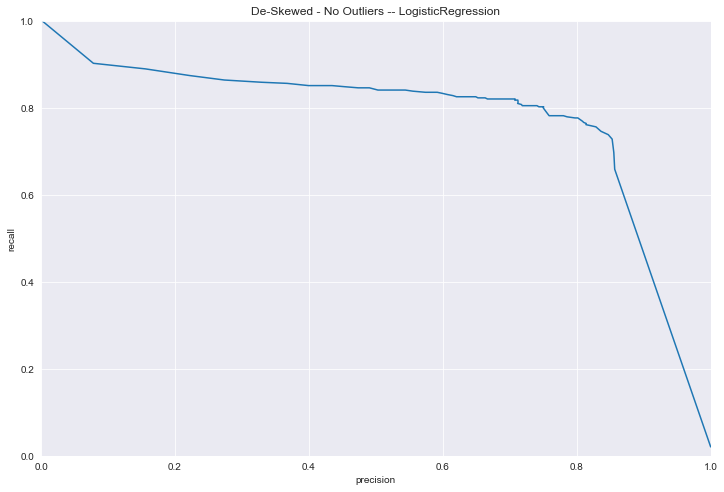

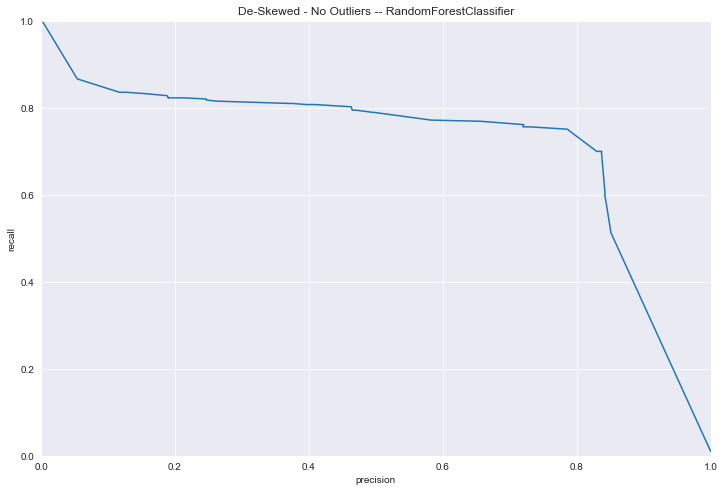

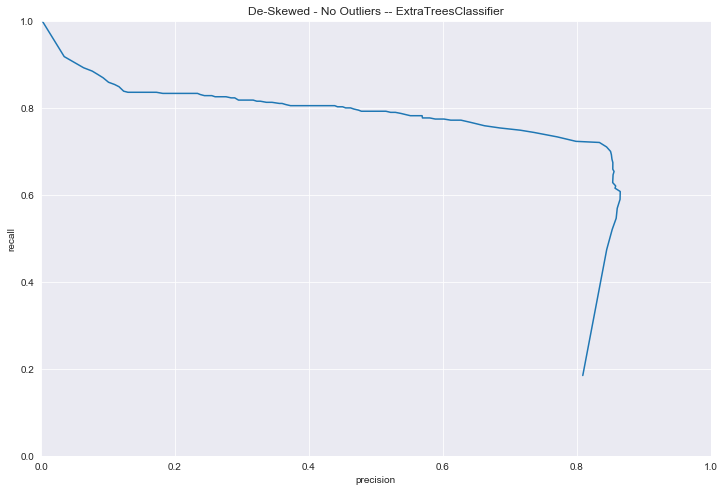

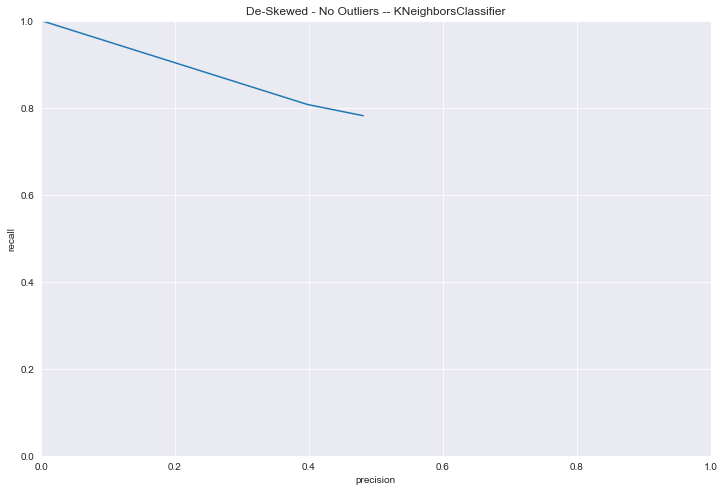

In [9]:
transforms_labels = zip([df, scaled_df, deskewed, scaled_df, deskewed],
                        ['Regular', 'Scaled', 'De-Skewed', 'No Outliers', 'De-Skewed - No Outliers'])

clf_params = list(zip([LogisticRegression(), RandomForestClassifier(random_state = SEED),
                  ExtraTreesClassifier(random_state = SEED),KNeighborsClassifier()],
                 [lr_params, tree_params,tree_params,knn_params]))

# Modeling Helper function To grid search all models
results = mh.test_all_models(transforms_labels, clf_params, drop_cols=['Time', 'Class'], seed=SEED)

save_best_models(results, 'regular')

We see that all classifiers acheive a high AUC score on the data.
Th Random Forest and Extra Trees Classifiers perform about equally and achieve a higher F1 score than the Logistic Regression.

--------------